In [1]:
import numpy as np
import torch
import torch.nn as nn

npfile = np.load("./src/data/data-airfoils.npz")

In [2]:
print(npfile.keys())

KeysView(<numpy.lib.npyio.NpzFile object at 0x7f15ac4d8700>)


In [3]:
x = npfile["inputs"]
y = npfile['targets']

vx = npfile["vinputs"]
vy = npfile["vtargets"]

print("x : ", x.shape)
print("y : ", y.shape)
print("vx : ", vx.shape)
print("vy : ", vy.shape)

x :  (320, 3, 128, 128)
y :  (320, 3, 128, 128)
vx :  (80, 3, 128, 128)
vy :  (80, 3, 128, 128)


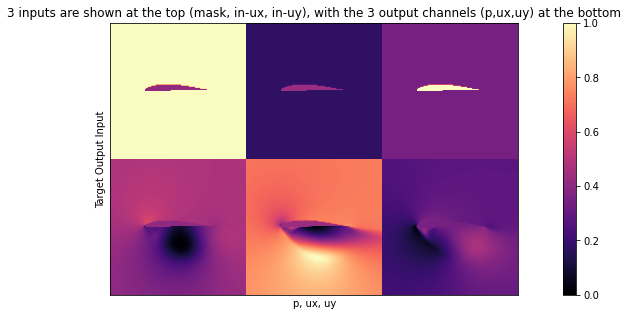

In [4]:
from src.utils.visualization import showSbs

NUM = 72
showSbs(x[NUM], y[NUM], stats = False, bottom = "Target Output", top = "Input", title="3 inputs are shown at the top (mask, in-ux, in-uy), with the 3 output channels (p,ux,uy) at the bottom"
)

In [5]:
from src.utils.datasets import DfpDataset
from torch.utils.data import DataLoader

tdata = DfpDataset(x,y)
vdata = DfpDataset(vx,vy)

BATCH_SIZE = 8

train_loader = DataLoader(tdata, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)
valid_loader = DataLoader(vdata, batch_size = BATCH_SIZE, shuffle = True, drop_last = True)

print("train loader # : ", len(train_loader))
print("valid loader # : ", len(valid_loader))

sample_x, sample_y = next(iter(train_loader))
print("sample_x : ", sample_x.size())
print("sample_y : ", sample_y.size())

train loader # :  40
valid loader # :  10
sample_x :  torch.Size([8, 3, 128, 128])
sample_y :  torch.Size([8, 3, 128, 128])


In [13]:
from src.model.network import DfpNet

if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

# hyper-parameter
EXPO = 3
LR = 1e-3
verbose = 4
num_epoch = 64

net = DfpNet(channelExponent = EXPO)
net.to(device)

# parameters count
nn_parameters = filter(lambda p : p.requires_grad, net.parameters())
params = sum([np.prod(p.size()) for p in nn_parameters])

print("training params : {}".format(params))

loss_fn = nn.L1Loss()
optimizer = torch.optim.AdamW(net.parameters(), lr = LR, betas = (0.5, 0.999), weight_decay = 0)

from src.utils.train import train
train_loss, valid_loss = train(net, train_loader, valid_loader, optimizer, loss_fn, num_epoch, device, verbose)

training params : 147363


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch : 1, train_loss : 0.287, valid_loss : 0.129
Epoch : 5, train_loss : 0.149, valid_loss : 0.121
Epoch : 9, train_loss : 0.133, valid_loss : 0.110
Epoch : 13, train_loss : 0.129, valid_loss : 0.110
Epoch : 17, train_loss : 0.125, valid_loss : 0.113
Epoch : 21, train_loss : 0.123, valid_loss : 0.109
Epoch : 25, train_loss : 0.126, valid_loss : 0.109
Epoch : 29, train_loss : 0.122, valid_loss : 0.109
Epoch : 33, train_loss : 0.123, valid_loss : 0.109
Epoch : 37, train_loss : 0.122, valid_loss : 0.108
Epoch : 41, train_loss : 0.125, valid_loss : 0.111
Epoch : 45, train_loss : 0.121, valid_loss : 0.108
Epoch : 49, train_loss : 0.125, valid_loss : 0.111
Epoch : 53, train_loss : 0.124, valid_loss : 0.109
Epoch : 57, train_loss : 0.122, valid_loss : 0.109
Epoch : 61, train_loss : 0.115, valid_loss : 0.109


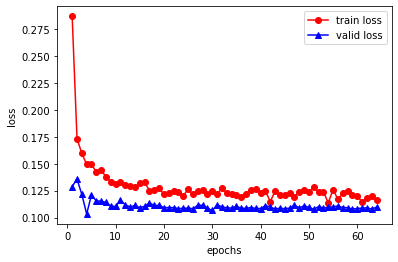

In [14]:
import matplotlib.pyplot as plt

x_epoch = range(1, len(train_loss)+1)
plt.plot(x_epoch, train_loss, 'ro-', label = "train loss")
plt.plot(x_epoch, valid_loss, 'b^-', label = "valid loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

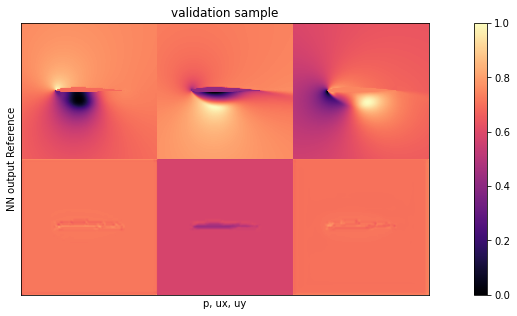

In [15]:
# for valid data
sample_input, sample_target = next(iter(valid_loader))

net.eval()
sample_output = net(sample_input.to(device))
sample_output = sample_output.detach().cpu().numpy()

showSbs(sample_target.cpu()[0], sample_output[0], title = "validation sample")

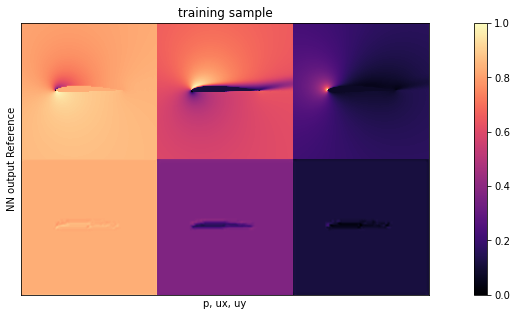

In [16]:
# for train data
sample_input, sample_target = next(iter(train_loader))

net.eval()
sample_output = net(sample_input.to(device))
sample_output = sample_output.detach().cpu().numpy()

showSbs(sample_target.cpu()[0], sample_output[0], title = "training sample")